<a href="https://colab.research.google.com/github/SamiMendonca/ESS130HW/blob/main/homework05_predicting_future_ocean_currents_githubcopy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EARTHSS 130 – Physical Oceanography
## Homework 05 – Limits to predictability: chaos, turbulence, and the closure problem

We have derived the rotating-frame Boussinesq equations (seven equations for seven variables) that govern the Eulerian evolution of ocean currents over time at a given location. The zonal momentum, for example, can be written in the form:
\begin{equation}
\frac{\partial u}{\partial t} = - \,\mathbf{u} \cdot \nabla u + fv - \frac{1}{\rho_{0}}\frac{\partial p}{\partial x} + \nu \nabla^{2} u.
\end{equation}
We have seen that **dimensional analysis** can tell us which terms are most important for a given problem, in some cases becoming **Ordinary Differential Equations (ODEs)** that we can solve directly (e.g. by guessing and verifying solutions on the Midterm equation sheet). We have also seen that we can even solve seemingly complicated **Partial Differential Equations** by **linearizing** (i.e. defining variables that are small fluctuations away from some average state) the equations and guessing linear wave solutions.

But what if we are in a parameter regime where dimensional analysis tells us that the non-linear terms (like $\mathbf{u}\cdot \nabla u$, which involves a product of the velocity vector and derivatives of the zonal velocity) are important and that fluctuations are relatively large, so that it is not appropriate to linearize the equations?

These nonlinearities bring us into the realm of turbulence. This Homework is a first exploration of the topic using a set of equations much, much simpler than the full Boussinesq governing equations.

### Introduction to *time-stepping*

The first-order Taylor series expansion in time $t$, with respect to a specific initial condition $t=t_{0}$, of the multivariable funtion $u(x,y,z,t)$ is given by:
\begin{equation}
  u(x,y,z,t) \approx u(x,y,z,t_{0}) + \frac{\partial u}{\partial t}\Big|_{x,y,z,t_{0}} (t-t_{0})
\end{equation}
If we then plug in the full zonal momentum equation, we can write the future velocity (at time $t$) in terms of spatial gradients of the present velocity (at time $t_{0}$),
\begin{equation}
  u(x,y,z,t) \approx u(x,y,z,t_{0}) + (t-t_{0}) \left[ - \,\mathbf{u} \cdot \nabla u + fv - \frac{1}{\rho_{0}}\frac{\partial p}{\partial x} + \nu \nabla^{2} u \right]_{x,y,z,t_{0}}.
\end{equation}

If we make thee *timestep* $\Delta t = t-t_{0}$ small enough, the approximation can become very accurate:
\begin{equation}
  u(x,y,z,t_{0}+\Delta t) = u(x,y,z,t_{0}) + \Delta t \left[ - \,\mathbf{u} \cdot \nabla u + fv - \frac{1}{\rho_{0}}\frac{\partial p}{\partial x} + \nu \nabla^{2} u \right]_{x,y,z,t_{0}}.
\end{equation}

If you evaluate this expression for $u(x,y,z,t_{0}+\Delta t)$ for all locations $(x,y,z)$ in the system, and do a similar thing to compute the updated $v(x,y,z,t_{0}+\Delta t)$ and $p(x,y,z,t_{0}+\Delta t)$, then you can plug those in to
\begin{equation}
  u(x,y,z,t_{0}+2\Delta t) = u(x,y,z,t_{0}+\Delta t) + \Delta t \left[ - \,\mathbf{u} \cdot \nabla u + fv - \frac{1}{\rho_{0}}\frac{\partial p}{\partial x} + \nu \nabla^{2} u \right]_{x,y,z,t_{0}+\Delta t},
\end{equation}
to predict the next timestep (at $t=t_{0}+2\Delta t$) and so on for any future time $t=t_{0}+n\Delta t$ as we take $n \rightarrow + \infty$.

Oceanographic simulations, weather forecasts, and climate projections all use computer programs to solve some form of this equation (and similar ones for other variables like temperature, density, and pressure) and thereby predict future currents and/or winds.


### A toy version of a computational ocean model

As an extremely crude simplification, use dimensional analysis to replace spatial derivatives $\frac{\partial}{\partial x} \rightarrow \frac{1}{L}$, where $L$ is a constant length scale, and second derivatives with $\frac{\partial^{2}}{\partial x^{2}} \rightarrow -\frac{1}{L^{2}}$ (negative because we have have seen that diffusion acts to decrease extrema and smooth things out over time). We also assume a constant pressure gradient force ($\frac{\partial p}{\partial x} = \frac{\Delta p}{L}$) and ignore the Coriolis force.

Under these (severe) approximations, the local evolution of zonal velocity $u(x,y,z,t_{0}+\Delta t) \rightarrow u(t_{0}+\Delta t)$ is given by:

\begin{equation}
u(t_{0}+\Delta t) = u(t_{0}) + \Delta t \left[ -u(t_{0}) \frac{u(t_{0})}{L} - \frac{\nu}{L^{2}} u(t_{0}) - \frac{\Delta p}{\rho_{0} L} \right]
\end{equation}
or

---

\begin{equation}
u(t_{0}+\Delta t) = - \left( \frac{\Delta t}{L} \right) [u(t_{0})]^{2} + \left( 1 - \frac{\Delta t \; \nu}{L^{2}} \right) u(t_{0}) - \left(\frac{\Delta p \, \Delta t}{\rho_{0} L} \right),
\end{equation}

---

in which everything is a known constant. Your task is to write simple computer programs that use this equation to predict the future.


# Setting up our algorithm
This code cell sets up some of the core functions and libraries that we will use.

**You do not need to change anything in the following code cell!**

In [1]:
# The following commands load in Python "packages" (i.e. libraries of code)
# that allow us to do things like visualize our data in graphs
import numpy as np
import matplotlib.pyplot as plt


def ocean_current_predictor(timestepper, u0, n):

  assert (u0>-1) & (u0<1), "u0 must be in the interval (-1, 1), excluding the endpoints"

  u = u0 # current value to u to the provided initial condition
  u_array = np.zeros(n+1) # we create an array of all zeros; will overwrite later
  for t in range(0,n+1): # start at t=1 because we already saved the initial condition at t=0
    u_array[t] = u # save our current value before timestepping
    u = timestepper(u)

  return u_array

def labelled_plot(u_array):
  l = plt.plot(u_array, "o", markersize=3)
  plt.plot(u_array, "-", color=l[0].get_color(), alpha=0.5)
  plt.xlabel(r"$n$")
  plt.ylabel(r"$u$")
  plt.xlim(0, len(u_array))
  if np.all(np.abs(u_array) <= 1):
    plt.ylim(-1, 1)

def labelled_histogram(u_array):
  du = 0.01
  plt.hist(u_array, bins=np.arange(-1, 1+du, du), alpha=0.5)
  plt.xlim(-1, 1)
  plt.xlabel(r"$u$")
  plt.ylabel(r"number of times $u$ falls within each bin")
  plt.title("Histogram (or probability distribution) of $u$")

#### Example: Understanding the `ocean_current_predictor` function

Let us consider the simple case in which we ignore the effects of non-linear momentum advection and fraction, so that our equation is simply:
\begin{equation}
u(t_{0}+\Delta t) = u(t_{0}) - \left(\frac{\Delta p \, \Delta t}{\rho_{0} L} \right),
\end{equation}
and further suppose the constant in parentheses is simply $\frac{\Delta p \, \Delta t}{\rho_{0} L} = -1$, so that
\begin{equation}
u(t_{0}+\Delta t) = u(t_{0} + \Delta t) + 1,
\end{equation}
which we write more concisely as the series defined by:
\begin{equation}
u_{n+1} = u_{n} + 1
\end{equation}

The following code demonstrates how we can define a `timestepper` function that takes a given $u_{n}$ as an input and *returns* $u_{n+1}$ as an output.

In [2]:
u0 = 0. # We assign the value `0` to our initial condition variable u(t0)=`u0`

def timestepper_add1(u): # we define the function `timestepper_add1, that depends on the input argument in parentheses
  u_next = u+1 # adds `1` to the argument `u` and assigns the result to a new variable `u_next`
  return u_next # returns the prediction for the next timestep, `u_next`

timestepper_add1(u0) # evaluates the function `timestepper_add1` for the input value u0 (defined above)

1.0

By applying this function iteratively, we can compute $u_{n}$ for any $n$, here up to n=3!

In [3]:
u1 = timestepper_add1(u0)
u2 = timestepper_add1(u1)
u3 = timestepper_add1(u2)
print(u0, u1, u2, u3)

0.0 1.0 2.0 3.0


Doing this manually is not practical for large $n$, so instead I provide the `ocean_current_predictor` function which takes the following inputs: 1) a `timestepper` function, 2) the initial condition `u0`, and 3) the number of timesteps $n$.

In [4]:
un = ocean_current_predictor(timestepper_add1, u0, n=3)

The function `labelled_plot` makes a nice graph of the timeseries:

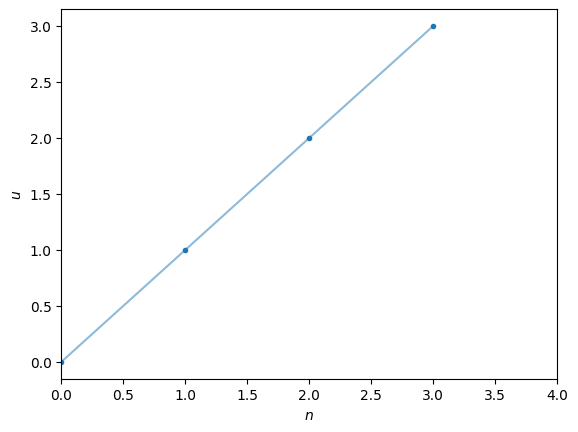

In [5]:
labelled_plot(un)

## Problem 1: Predicting the future with a *linear* toy model

Consider another simple case in which we again ignore the non-linear term, but now include the frictional effect and consider the simple case in which $\frac{\Delta t \, \nu}{L^{2}} = 1.5$, which gives the simple series equation:

---

\begin{equation}
u_{n+1} = - \,0.5 \, u_{n} + 1,
\end{equation}

---

**a)** Write code for the function `timestepper_linear` that corresponds to the difference equation above and run it through `ocean_current_predictor` with a few choices of initial conditions `u0` within the interval `(-1,1)` and numbers of timesteps `n` to convince yourself that it is working properly.

Hint: mutliplication in Python is with the `*` symbol, i.e. `-2*5` gives `-10`.

In [12]:
def timestepper_linear(un):
  # Write your function here, following the `timestepper_add1` example above
  un_plus1= -0.5*un+1 #-0.5 is the linear slope, +1 is +b given y=mx+b
  return un_plus1

In [14]:
# Test your function by writing code here
un = ocean_current_predictor(timestepper_linear,u0,n=3)
print (un)

[0.   1.   0.5  0.75]


**b)** Run the `ocean_current_predictor` for $n = 50$ timesteps and several different choices of initial conditions. Use the `labelled_plot` function to visualize your results.

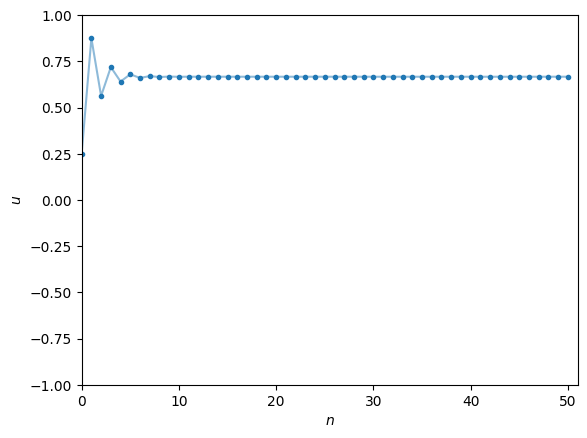

In [25]:
# Write your code here
un = ocean_current_predictor(timestepper_linear, 0.25, n=50)
labelled_plot (un)

**Describe** your results in this "text" cell of the notebook by double clicking on the cell and typing between the two horizontal lines:

---

The code would not run unless the initial condition was u0. I attempted u4 initially, and the returned message stated that u4 was not defined. I then attempted u3, but the returned message stated that it must begin at a number represented by u0. I also tried u2, in case it had defined u0 in place of the first initial condition, then u1 and u2, but the same message returned, that it must start at u0.

I have found that the larger the decimal put in the place of u0, the shallower the slope, and the smaller the decimal, the steeper the slope.

Other than error messages, I noticed that the plot shows how the visualized results return to a more stable state. This implies that the predicted results are for a stratified current.

---

**c)** You should find in part (b) that your solutions trend towards a single steady state in which each future value of the zonal velocity $u_{n+1}$ is the same as the previous one $u_{n}$, i.e.
\begin{equation}
u_{n+1} = u_{n}.
\end{equation}
Plug the earlier definition for the series $u_{n+1}$ as a function of $u_{n}$ into here and rearrange the resulting equation to solve for the equilbrium solution $u_{n}$. How does this compare to your computational results for large $n$?

---

Write your solution here, using *LaTeX* notation to modify the following equation (you can double-click through my various equations to see how LaTeX is formatted or google a tutorial):
\begin{equation}
  u_{n} = ?
\end{equation}

---

## Problem 2: Predicting the future with a *nonlinear* toy model

Let us now consider a case in which we include the *nonlinear* advection term. For simplicity, we assume that $\frac{\Delta t}{L} = 2$, that $\frac{\Delta t \, \nu}{L^{2}} = 1$ (such that the coefficient for the linear term proportional to $u(t_{0})$ vanishes), and again that $\frac{\Delta p \Delta t}{\rho_{0}L} = -1$. We are left with the resulting *nonlinear* difference equation:

---

\begin{equation}
u_{n+1} = -2(u_{n})^{2} + 1
\end{equation}

---

**a)** Write code for the function `timestepper_nonlinear` that corresponds to the difference equation above.

*Hint:* exponentiation in Python is with the `**` operator, i.e. `2**3` is equal to `2*2*2` is equal to `8`.

In [22]:
def timestepper_nonlinear(un):
  # Write your function here, following the `timestepper_add1` example above
  unPlus1 = -2*(un**2)+1
  return unPlus1

**b)** Pick several random values of `u0` in the interval `(-1,1)` and run in through the `ocean_current_predictor` for `n=100`. **Describe your results.** Does the solution settle into a some predictable steady state (like the linear model), exhibit some kind of regular repeating pattern, or exhibit some other kind of behavior?

In [ ]:
# Write your code here.

---

Write your text answer here.

---

**c)** Pick any value for the initial condition `u0` (except for `u0=0`, `u0=0.5`, or `u0=-0.5`, which are special cases) and run a simulation for $n=100$. Repeat the simulation with a slightly different initial condition `u0+0.001` and again with an initial condition that is only off by one trillionth, `u0+1e-12`. Plot all three simulations one the same plot.

When you restart a nonlinear simulation from essentially the same initial condition, **how** similar is the evolution of $u_{n}$?

Given that we inevitably have some errors in measuring the present state of the climate, **explain** the implications of this result for making weather forecasts or climate projections starting from an *imperfectly known* initial condition.

In [ ]:
# Write your code here

---
Write your text answer here.

---

**d)** Use the `labelled_histogram` plotting function demonstrated below to compare the *statistics* the simulation with initial condition `u0` and the one with the infinitesimally different initial condition `u0+1e-12`. **How** do they compare?

Repeat these two simulations but now for many more timesteps, `n=1e6`. Compare value of the millionth timestep, $u_{1e6}$ (you can sample the last element of the sequence or array with `un[-1]`) and compare their histograms. Discuss the implications for predicting a specific weather event vs. multidecadal changes in Earth's climate.

0.5


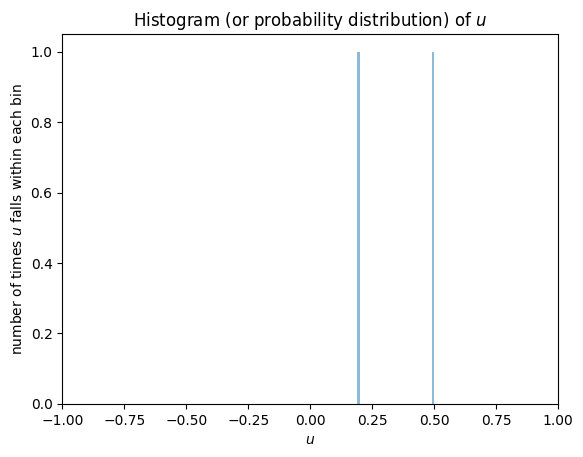

In [ ]:
## Modify the code in this cell

un = np.array([0.2,0.5])

print(un[-1])

labelled_histogram(un)

---

Write your interpretation here.

---